In [1]:
import requests
import math
from datetime import datetime, timezone, timedelta
import pandas as pd
from pandas.io.json import json_normalize
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import numpy as np

## Data Pre-Processing

In [2]:
def download_ohlcv(symbol, start_date, end_date):
    date_iterator = start_date - timedelta(hours=1)
    
    ohlcv_df = pd.DataFrame()
    
    while date_iterator < end_date:
        delta = timedelta(seconds=min((end_date - date_iterator).total_seconds(), 2000 * 3600))
        limit = delta.total_seconds() // 3600 - 1
        date_iterator += delta
        
        params={
            'fsym': symbol,
            'tsym': 'USD',
            'limit': limit,
            'toTs': date_iterator.timestamp()
        }
        
        r = requests.get('https://min-api.cryptocompare.com/data/histohour', params=params)
        data = json_normalize(r.json(), record_path="Data")
        ohlcv_df = ohlcv_df.append(data)

    ohlcv_df['time'] = pd.to_datetime(ohlcv_df['time'], unit='s')
    ohlcv_df.set_index('time', inplace=True)
    ohlcv_df = ohlcv_df.tz_localize('UTC')
    
    return ohlcv_df

In [3]:
def download_trends(keyword, start_date, end_date):
    pytrends = TrendReq()

    delta = timedelta(days=7)
    date_iterator = start_date

    trends_df = pd.DataFrame()
    
    while date_iterator < end_date:
        week_start = date_iterator.strftime('%Y-%m-%dT%H')
        week_end = (date_iterator + delta).strftime('%Y-%m-%dT%H')
        tf = week_start + ' ' + week_end

        pytrends.build_payload([keyword], timeframe=tf)
        week_df = pytrends.interest_over_time()

        if (not trends_df.empty):
            ratio = trends_df[trends_df.index == date_iterator].iloc[0][keyword] / week_df[week_df.index == date_iterator].iloc[0][keyword]
            trends_df[keyword] /= ratio

        trends_df = trends_df.append(week_df)
        
        date_iterator += delta
        
    trends_df = trends_df[~trends_df.index.duplicated(keep='last')]
    trends_df.rename(columns={keyword: 'trend'}, inplace=True)
    trends_df.drop(columns='isPartial', inplace=True)
    trends_df['trend'] *= 100 / np.max(trends_df['trend'])
    trends_df = trends_df.tz_localize('UTC')
    
    return trends_df

In [4]:
start_date = datetime(2018, 3, 30, 0)
end_date = datetime(2018, 9, 30, 0)
symbol = 'BTC'
keyword = 'Bitcoin'

In [5]:
ohlcv_df = download_ohlcv('BTC', start_date, end_date)

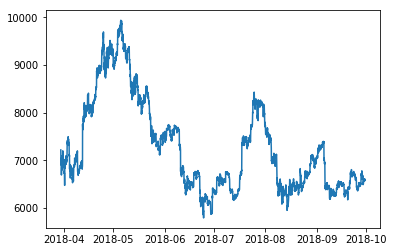

In [6]:
plt.plot(ohlcv_df.index.values, ohlcv_df['close'])

In [7]:
trends_df = download_trends('Bitcoin', start_date, end_date)

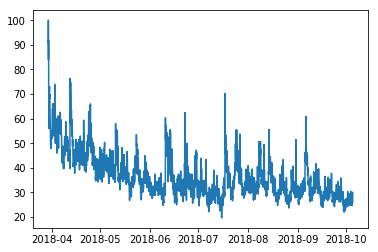

In [8]:
plt.plot(trends_df.index.values, trends_df['trend'])

In [9]:
raw_df = ohlcv_df.join(trends_df, how="inner")

In [10]:
proc_df = pd.DataFrame()

proc_df['open_close_ratio'] = raw_df['open'] / raw_df['close'] - 1
proc_df['high_low_ratio'] = raw_df['high'] / raw_df['low'] - 1

proc_df['close_pct_change_1hr'] = raw_df['close'].pct_change()
proc_df['close_pct_change_6hr'] = raw_df['close'].pct_change(periods=6)
proc_df['close_pct_change_12hr'] = raw_df['close'].pct_change(periods=12)
proc_df['close_pct_change_24hr'] = raw_df['close'].pct_change(periods=24)

proc_df['volume_pct_change_1hr'] = raw_df['volumefrom'].pct_change()
proc_df['volume_pct_change_6hr'] = raw_df['volumefrom'].pct_change(periods=6)
proc_df['volume_pct_change_12hr'] = raw_df['volumefrom'].pct_change(periods=12)
proc_df['volume_pct_change_24hr'] = raw_df['volumefrom'].pct_change(periods=24)

proc_df['trend_pct_change_1hr'] = raw_df['trend'].pct_change()
proc_df['trend_pct_change_6hr'] = raw_df['trend'].pct_change(periods=6)
proc_df['trend_pct_change_12hr'] = raw_df['trend'].pct_change(periods=12)
proc_df['trend_pct_change_24hr'] = raw_df['trend'].pct_change(periods=24)

proc_df.dropna(inplace=True)

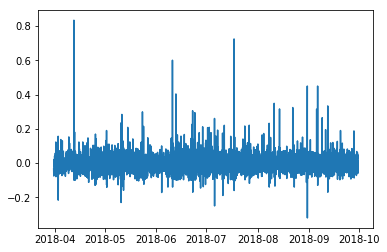

In [12]:
plt.plot(proc_df.index.values, proc_df['trend_pct_change_1hr'])

## Model

In [13]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [14]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(proc_df), columns=proc_df.columns)

In [35]:
unrolled_cells = 6
timestep = 1
num_features = len(scaled_df.columns)
learning_rate = 0.00001
num_epoch= 5000
batch_size= 32
num_layers = 5
layer_size = 20
lambda_l2 = 0.005

sequences = []
targets = []

for i in range(0, len(scaled_df) - unrolled_cells, timestep):
    sequences.append(scaled_df[i:i+unrolled_cells].values)
    targets.append([scaled_df['close_pct_change_1hr'][i+unrolled_cells]])

In [44]:
def lstm_cell_with_dropout():
    lstm_cell = tf.nn.rnn_cell.LSTMCell(layer_size)
    return tf.nn.rnn_cell.DropoutWrapper(lstm_cell)

tf.reset_default_graph()    

X = tf.placeholder('float32', [None, unrolled_cells, num_features])
Y = tf.placeholder('float32', [None, 1])

x = tf.unstack(X, unrolled_cells, axis=1)

stacked_lstm = tf.contrib.rnn.MultiRNNCell([lstm_cell_with_dropout() for _ in range(5)])
rnn_outputs, rnn_states = tf.contrib.rnn.static_rnn(stacked_lstm, x, dtype=tf.float32)

prediction = tf.layers.dense(rnn_outputs[-1], 1)

tv = tf.trainable_variables()
l2 = lambda_l2 * tf.reduce_sum([ tf.nn.l2_loss(v) for v in tv if not ("noreg" in v.name or "Bias" in v.name)])

loss = tf.losses.mean_squared_error(Y, prediction) + l2
optimizer = tf.train.AdamOptimizer(learning_rate)
minimize = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()

In [45]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(1, num_epoch+1):
        for start in range(0, len(sequences) + 1, batch_size):
            batch_x = sequences[start:min(start+batch_size, len(sequences))]
            batch_y = targets[start:min(start+batch_size, len(targets))]
            
            sess.run(minimize, feed_dict={X: batch_x, Y: batch_y})
            
        train_loss = sess.run([loss], feed_dict={X: batch_x, Y: batch_y})
        
        print(f'Epoch {epoch}: {train_loss}')

Epoch 1: [0.7679842]
Epoch 2: [0.7490077]
Epoch 3: [0.7299996]
Epoch 4: [0.71083164]
Epoch 5: [0.69144285]
Epoch 6: [0.6718362]
Epoch 7: [0.6520792]
Epoch 8: [0.63231844]
Epoch 9: [0.61279243]
Epoch 10: [0.5938231]
Epoch 11: [0.5757877]
Epoch 12: [0.5590617]
Epoch 13: [0.543919]
Epoch 14: [0.5304247]
Epoch 15: [0.5183935]
Epoch 16: [0.5074713]
Epoch 17: [0.4972926]
Epoch 18: [0.48758847]
Epoch 19: [0.4781994]
Epoch 20: [0.46904022]
Epoch 21: [0.46006572]
Epoch 22: [0.4512507]
Epoch 23: [0.44257993]
Epoch 24: [0.43404338]
Epoch 25: [0.42563376]
Epoch 26: [0.4173459]
Epoch 27: [0.40917575]
Epoch 28: [0.40111986]
Epoch 29: [0.39317563]
Epoch 30: [0.38534078]
Epoch 31: [0.37761346]
Epoch 32: [0.36999208]
Epoch 33: [0.36247528]
Epoch 34: [0.3550617]
Epoch 35: [0.34775037]
Epoch 36: [0.34054035]
Epoch 37: [0.33343062]
Epoch 38: [0.32642046]
Epoch 39: [0.31950915]
Epoch 40: [0.31269598]
Epoch 41: [0.30598038]
Epoch 42: [0.2993616]
Epoch 43: [0.2928391]
Epoch 44: [0.28641236]
Epoch 45: [0.2800

Epoch 333: [0.0014762538]
Epoch 334: [0.0014725702]
Epoch 335: [0.0014689093]
Epoch 336: [0.001465271]
Epoch 337: [0.0014616536]
Epoch 338: [0.0014580586]
Epoch 339: [0.0014544844]
Epoch 340: [0.0014509314]
Epoch 341: [0.0014473986]
Epoch 342: [0.0014438867]
Epoch 343: [0.0014403939]
Epoch 344: [0.001436923]
Epoch 345: [0.0014334711]
Epoch 346: [0.0014300391]
Epoch 347: [0.0014266261]
Epoch 348: [0.0014232327]
Epoch 349: [0.0014198569]
Epoch 350: [0.0014165007]
Epoch 351: [0.0014131621]
Epoch 352: [0.0014098424]
Epoch 353: [0.0014065406]
Epoch 354: [0.0014032573]
Epoch 355: [0.0013999919]
Epoch 356: [0.001396744]
Epoch 357: [0.001393513]
Epoch 358: [0.0013902986]
Epoch 359: [0.0013871009]
Epoch 360: [0.0013839199]
Epoch 361: [0.0013807543]
Epoch 362: [0.0013776055]
Epoch 363: [0.0013744736]
Epoch 364: [0.0013713574]
Epoch 365: [0.0013682565]
Epoch 366: [0.001365172]
Epoch 367: [0.0013621016]
Epoch 368: [0.0013590468]
Epoch 369: [0.0013560071]
Epoch 370: [0.0013529821]
Epoch 371: [0.001

Epoch 648: [0.0007803835]
Epoch 649: [0.0007788344]
Epoch 650: [0.00077728945]
Epoch 651: [0.0007757474]
Epoch 652: [0.0007742081]
Epoch 653: [0.00077267154]
Epoch 654: [0.0007711395]
Epoch 655: [0.00076960947]
Epoch 656: [0.00076808105]
Epoch 657: [0.0007665538]
Epoch 658: [0.00076502934]
Epoch 659: [0.0007635083]
Epoch 660: [0.0007619894]
Epoch 661: [0.0007604752]
Epoch 662: [0.0007589639]
Epoch 663: [0.0007574556]
Epoch 664: [0.0007559508]
Epoch 665: [0.00075444556]
Epoch 666: [0.0007529412]
Epoch 667: [0.0007514405]
Epoch 668: [0.00074994407]
Epoch 669: [0.0007484499]
Epoch 670: [0.0007469583]
Epoch 671: [0.0007454715]
Epoch 672: [0.0007439883]
Epoch 673: [0.0007425066]
Epoch 674: [0.0007410254]
Epoch 675: [0.00073954486]
Epoch 676: [0.00073806685]
Epoch 677: [0.00073659385]
Epoch 678: [0.0007351228]
Epoch 679: [0.00073365815]
Epoch 680: [0.00073219574]
Epoch 681: [0.0007307357]
Epoch 682: [0.00072927575]
Epoch 683: [0.00072781893]
Epoch 684: [0.00072636147]
Epoch 685: [0.000724908

KeyboardInterrupt: 